In [2]:
!wget https://www.dropbox.com/scl/fi/owk9udhb67unkxmmpqxuu/data.json?rlkey=epm3joq5td0g1cz8ejxlygxgu&st=jqtho6zp&dl=0
!mv /content/data.json?rlkey=epm3joq5td0g1cz8ejxlygxgu /content/data.json

--2024-06-17 06:15:18--  https://www.dropbox.com/scl/fi/owk9udhb67unkxmmpqxuu/data.json?rlkey=epm3joq5td0g1cz8ejxlygxgu
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5b8e28b4ecb8be7ec61c75b420.dl.dropboxusercontent.com/cd/0/inline/CU_Y8wQLTE99_m4r7hd8RtR6oQ-5R2vnrTu6xeIVl0Vms0JLys9INjDXALgIIJaBJVOf0y5h7viBQ0AEI5C6e5768hSHOJOsAb_SnFHyzMI1m2WGTWji9OklQQ2QicxusIK8SKTs-lTrbxZp7jbJRRYx/file# [following]
--2024-06-17 06:15:18--  https://uc5b8e28b4ecb8be7ec61c75b420.dl.dropboxusercontent.com/cd/0/inline/CU_Y8wQLTE99_m4r7hd8RtR6oQ-5R2vnrTu6xeIVl0Vms0JLys9INjDXALgIIJaBJVOf0y5h7viBQ0AEI5C6e5768hSHOJOsAb_SnFHyzMI1m2WGTWji9OklQQ2QicxusIK8SKTs-lTrbxZp7jbJRRYx/file
Resolving uc5b8e28b4ecb8be7ec61c75b420.dl.dropboxusercontent.com (uc5b8e28b4ecb8be7ec61c75b420.dl.dropboxusercontent.com)... 162.125.1.15, 2620:100:

In [3]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [4]:
DATASET_PATH = '/content/data.json'
EPOCHS = 50
BATCH_SIZE = 32

GENRE = {
    0: 'blues',
    1: 'classical',
    2: 'country',
    3: 'disco',
    4: 'hiphop',
    5: 'jazz',
    6: 'metal',
    7: 'pop',
    8: 'reggae',
    9: 'rock'
}

In [5]:
def load_data(dataset_path):
  with open(dataset_path) as fp:
    data = json.load(fp)

    # convert lists into numpy array
    inputs = np.array(data['mfcc'])
    targets = np.array(data['labels'])

    return inputs, targets

In [6]:
def prepare_datasets(dataset_path, test_size, val_size):
  X, y = load_data(DATASET_PATH)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size)

  # X_train = X_train[..., np.newaxis]
  # X_val = X_val[..., np.newaxis]
  # X_test = X_test[..., np.newaxis]

  return X_train, X_val, X_test, y_train, y_val, y_test

In [7]:
def predict(model, X):
  X = X[np.newaxis, ...]

  y_pred = model.predict(X, verbose=0)
  y_pred = np.argmax(y_pred, axis=1)

  return y_pred[0]

In [8]:
def create_model(input_shape):

  model = Sequential()

  model.add(LSTM(units=64, input_shape=input_shape, return_sequences=True))
  model.add(LSTM(units=64))

  model.add(Dense(units=128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  model.add(Dropout(0.3))
  model.add(Dense(units=64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  model.add(Dropout(0.3))
  model.add(Dense(units=32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  model.add(Dropout(0.3))

  model.add(Dense(units=10, activation='softmax'))

  return model

In [9]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_datasets(DATASET_PATH, test_size=0.2, val_size=0.25)

In [26]:
input_shape = (X_train.shape[1], X_train.shape[2])
model = create_model(input_shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 130, 64)           19968     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)               

In [27]:
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0.001,
                              patience=5,
                              restore_best_weights=True,
                              verbose=True)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy',
                                        patience=2,
                                        factor=0.5,
                                        verbose=True)

checkpoint = ModelCheckpoint('best_weights.keras', save_best_only=True, monitor='val_accuracy', mode='max')
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [28]:
# model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[checkpoint, early_stopping, reduce_learning_rate], verbose=2)
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)

Epoch 1/50
188/188 - 10s - loss: 2.5031 - accuracy: 0.1276 - val_loss: 2.4501 - val_accuracy: 0.2376 - 10s/epoch - 54ms/step
Epoch 2/50
188/188 - 2s - loss: 2.4138 - accuracy: 0.1953 - val_loss: 2.3125 - val_accuracy: 0.2931 - 2s/epoch - 12ms/step
Epoch 3/50
188/188 - 2s - loss: 2.2839 - accuracy: 0.2543 - val_loss: 2.1449 - val_accuracy: 0.3492 - 2s/epoch - 12ms/step
Epoch 4/50
188/188 - 2s - loss: 2.1400 - accuracy: 0.3082 - val_loss: 1.9887 - val_accuracy: 0.3752 - 2s/epoch - 12ms/step
Epoch 5/50
188/188 - 3s - loss: 2.0131 - accuracy: 0.3577 - val_loss: 1.8610 - val_accuracy: 0.4002 - 3s/epoch - 16ms/step
Epoch 6/50
188/188 - 4s - loss: 1.9201 - accuracy: 0.3864 - val_loss: 1.8013 - val_accuracy: 0.4247 - 4s/epoch - 19ms/step
Epoch 7/50
188/188 - 2s - loss: 1.8552 - accuracy: 0.3994 - val_loss: 1.7526 - val_accuracy: 0.4352 - 2s/epoch - 12ms/step
Epoch 8/50
188/188 - 2s - loss: 1.7885 - accuracy: 0.4204 - val_loss: 1.7117 - val_accuracy: 0.4512 - 2s/epoch - 12ms/step
Epoch 9/50
188

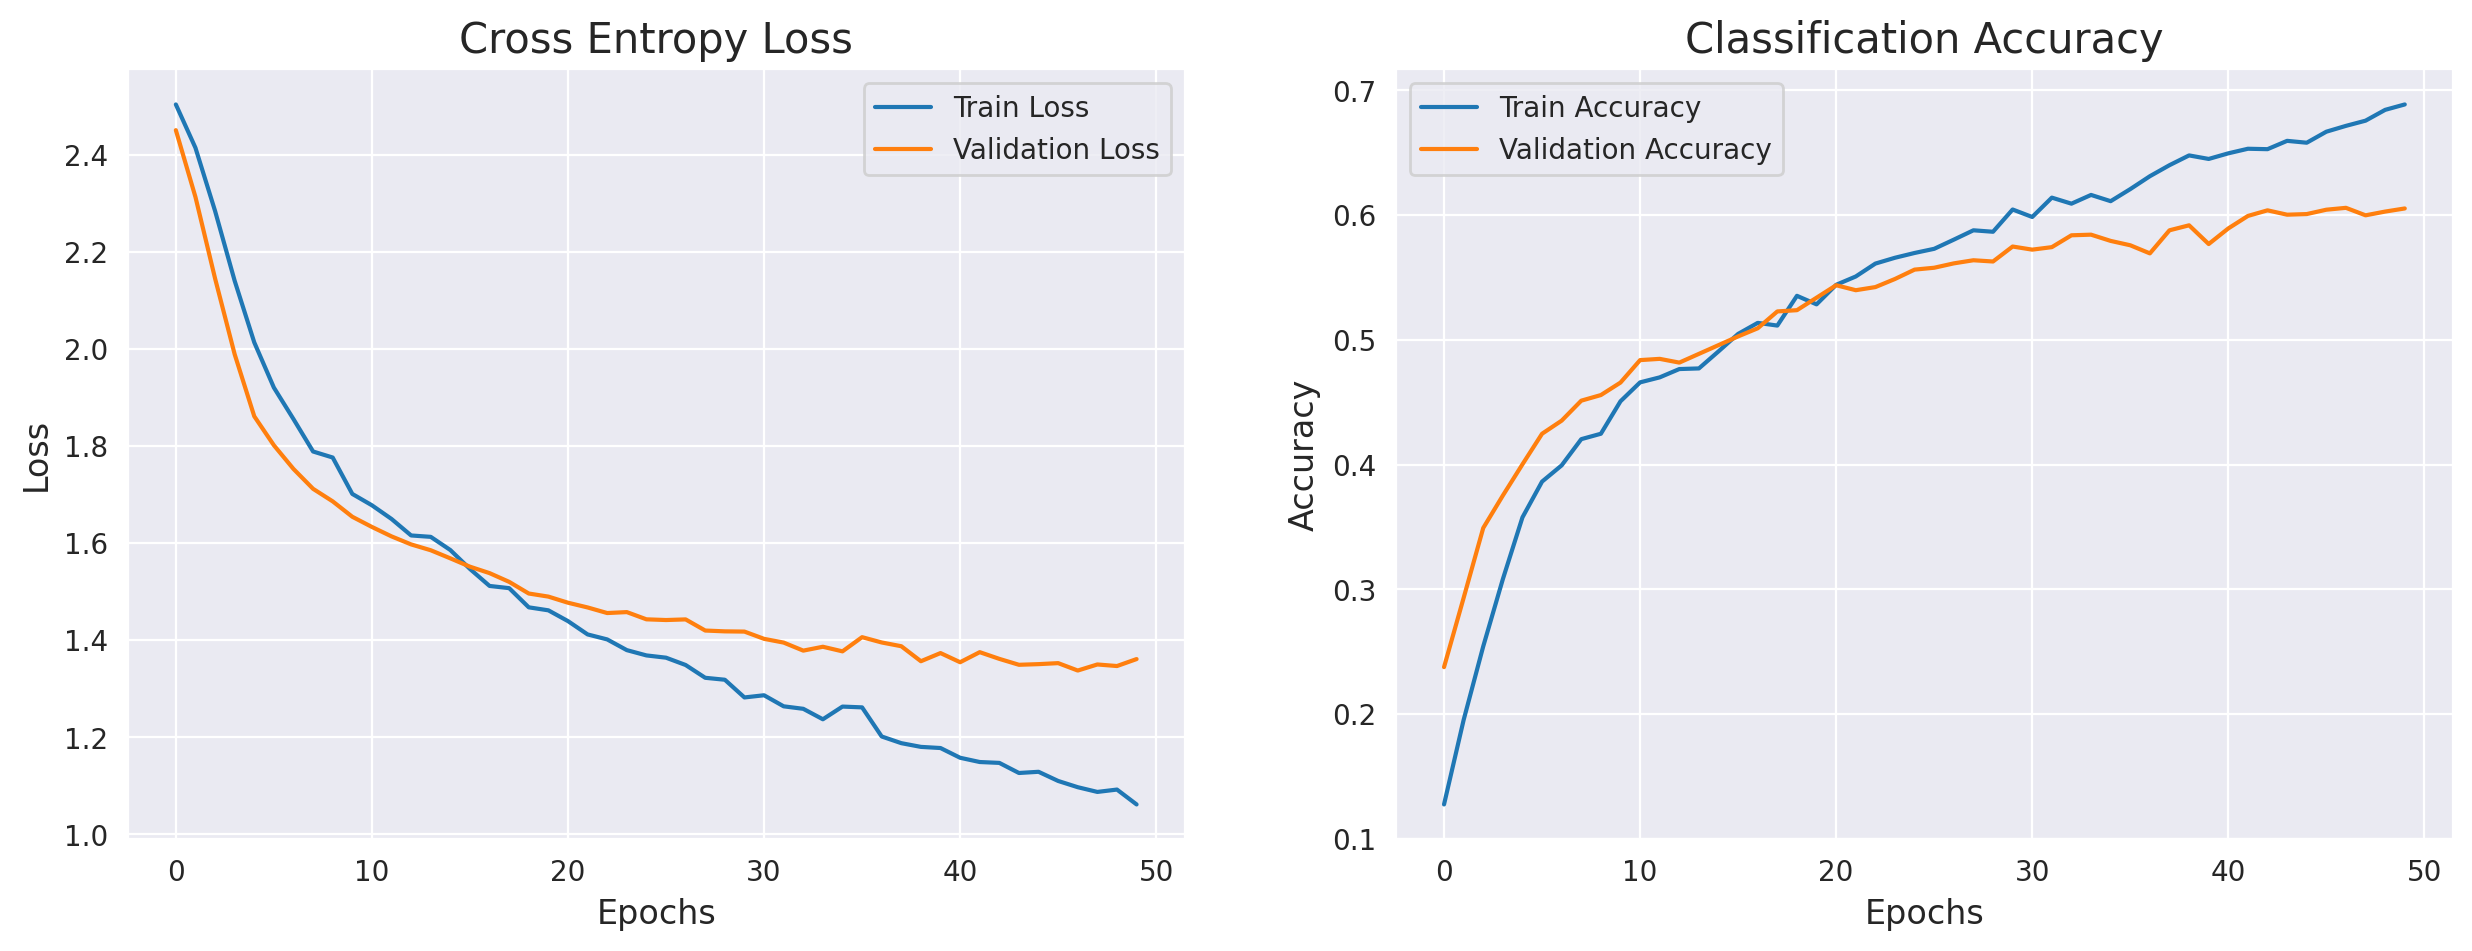

In [29]:
metrics = pd.DataFrame(model.history.history)

plt.figure(figsize=(15,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(metrics['loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(metrics['accuracy'], label='Train Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.show()

In [30]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Error: {test_error}')
print(f'Test Accuracy: {test_accuracy}')

Test Error: 1.3021694421768188
Test Accuracy: 0.6129999756813049


In [33]:
X = X_test[66]
y = y_test[66]

y_pred = predict(model, X)

print(f'Actual class: {GENRE[y]}')
print(f'Predicted class: {GENRE[y_pred]}')

Actual class: metal
Predicted class: metal
